# A hands-on machine learning tutorial for astrophysics

**Author**: Nicolas Audebert (<nicolas.audebert@cnam.fr>)

https://sftools-bigdata.sciencesconf.org/

## Introduction

Welcome to this machine learning tutorial! This notebook is designed as a short tour of statistical learning covering both unsupervised and supervised learning techniques. We will apply well-known ML algorithms on two astronomical datasets representative of the most common usecases: mining of tabular data and image processing.

This tutorial assumes that you are at least somewhat familiar with Python and its scientific computing ecosystem (e.g. NumPy, SciPy, pandas…) but don't worry if you're not an expert: it's not too hard to grasp the fundamentals.

This is **not**:
* a tutorial on astro-oriented ML packages (such as astropy, astroML or astroNN),
* a comprehensive demonstration of scikit-learn or PyTorch,
* a machine learning class.

Rather, this hands-on tutorial is designed to be a progressive introduction to machine learning concepts and algorithms illustrated by code examples on real-world datasets. We will mostly focus on supervised techniques for classification, which are the most common.


Let's dive in.

**Note:** if you work with Google Colab, be sure to use a GPU for improved performance (Edit > Notebook parameters > check that GPU is selected

In [84]:
!pip install numpy matplotlib seaborn pandas torch torchvision scikit-learn scikit-image skorch umap-learn h5py tqdm

First, we'll import some libraries that will be useful for later.

In [85]:
# Graphs and figures
import matplotlib.pyplot as plt
import seaborn as sns

# Data/arrays manipulation
import numpy as np
np.random.seed(0) # for reproducibility
import pandas as pd

# Machine learning !
import sklearn

## ML on tabular data: star type classification

We will start with a very common use case: tabular data. We assume that we have a set of observations (rows) and that for each one we have a set of measurements or *features* (columns). In this case, we will work with a star catalogue of 240 stars described by the following information:

- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue/…)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)

This dataset has been collected by [Deepraj Baidya](https://github.com/deepraj1729) and was originally published on [Kaggle](https://www.kaggle.com/deepu1109/star-dataset). Measurements were collected either from Wikipedia or derived from the laws of physics.

### Objective

We want to build a decisional model to help us categorize stars based on their observed properties. Mathematically, this means that we want to build a classification function that outputs:

$f: (x_1, x_2, ..., x_n) \in \mathbb{R}^n \rightarrow f(x_1, ..., x_n) = y \in \{0, 1, 2, ..., k-1\}$, where:

* $(x_1, ..., x_n)$ represent the features (i.e. the observed physical properties),
* $y$ represents the index of the class (i.e. the star type).

This is a toy example but that will be helpful to demonstrate some core concepts from machine learning.

### Loading and preprocessing of the data

We can use the `pandas` library to read the `.csv` catalogue.

In [86]:
import urllib.request
urllib.request.urlretrieve("https://nicolas.audebert.at/files/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x7fc0382d4b00>)

In [87]:
df_stars = pd.read_csv("stars.csv")

The dataset is comprised of 240 stars and their properties. Looking at the data, we can see that some of the variables are continuous values (e.g. temperature) while others are categorical (color and class).

In [88]:
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


Our goal with this dataset is try to learn a statistical that infers the star type based on its physical properties. There are 6 star types that are encoded in the *'Star type'* column. We call this information the **labels**.

The labels are currently encoded as strings which is practical for reading but not for computing. Using scikit-learn, we will convert this column into integers by assigning a unique int value to each star type. The `LabelEncoder` object is used to convert from a set of values to integers.

In [89]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


In [90]:
labels = le.inverse_transform(df_stars['Star type'])

We want to build a statistical model that learns how to map Temperature/Luminosity/Radius/Absolute magnitude to the star type. Since the labels are categorical, this task is called **classification**.

We will use a supervised approach: we build a model by training it on some examples for which we know the actual labels (the *ground truth*). Then, we will try to see if the model can infer the right star type on new data that it has not seen during training.

### Preliminary analysis

It is often grood practice to start with a statistical analysis of the dataset to answer the following questions:
* are there any missing values?
* are there NaNs in the data?
* are some variables redundant (i.e. strongly correlated)?
* is the data distribution skewed somehow?

We can start by plotting the correlations between variables:

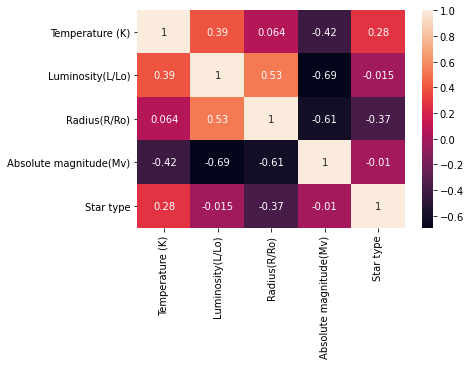

In [91]:
## Correlation between variables
sns.heatmap(df_stars.corr(), annot=True) and plt.show()

The star type is not correlated with any particular column from the catalogue. We can see that some variables are correlated (either positively or negatively) but not entirely redundant. If two variables were too strongly correlated, it might have been a good idea to remove one of the two.

Star classification is something that can be done based on rules depending on temperature and luminosity. For example, Wikipedia gives the following example of a Hertzsprung-Russell diagram:
![](https://upload.wikimedia.org/wikipedia/commons/6/6b/HRDiagram.png)

We can reproduce this diagram by plotting the scatter plot of our stars using the same variables in log-log-scale.

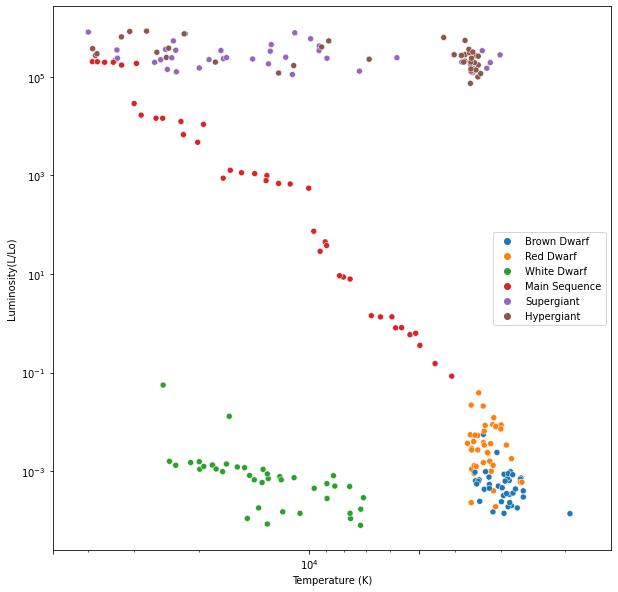

In [92]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)
plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

We find the same organization of stars in this 2D plane. Main Sequence stars and White Dwarves are fairly easy to isolate from the rest: a statistical model should be able to easily classify them. Based only on Luminosity and Temperature, Dwarf stars and Giant stars have higher intra-group variability: Supergiant and Hypergiant cover the same space (same for Brown and Red Dwarves). Additionnal variables might be needed to correctly identify the types of those stars.

### Dimension reduction

A first common step for data analysis is dimension reduction to reduce the number of features (column variables) in the dataset. There are two main uses for dimension reduction algorithms:

1. visualization by reducing the number of variables to 2 or 3
2. reducing the number of variables for easier data mining (e.g. fighting the curse of dimensionality)

A well-known dimension reduction algorithm is the **Principal Component Analysis** (PCA). PCA finds linear combinations of variables that explain most of the variance in the data.

`scikit-learn` offers a PCA module that is straightforward to use. Nearly all statistical models implemented in `sklearn` follow the same interface. Let's start by importing the module.

In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

By default, the ``PCA()`` object performs a full decomposition with as many components as there are input variables. However in this case we will perform a PCA for visualization using a 2D point cloud, so we can keep only the first 2 principal components.

Performing the actual PCA is done using the ``.fit()`` method on the data. We will keep only the physical measurements for this analysis. PCA is **unsupervised**, which means the model depends only the observations (and it does not require labels).

In [94]:
df_stars_data = df_stars.drop(columns=["Star color", "Star type", "Spectral Class"])
X = np.array(df_stars_data)

Note that scikit-learn expects a ``NumPy`` array. It will automatically convert the data that is fed into it into ``np.array`` if needed. In our case, the pandas table are converted on the fly. We won't do it manually in the rest of this notebook.

`X` now represents our data matrix on which we will be able to perform machine learning.

Let's apply a PCA on the dataset. PCA will project our data in a 2-dimensional space that maximizes variance:

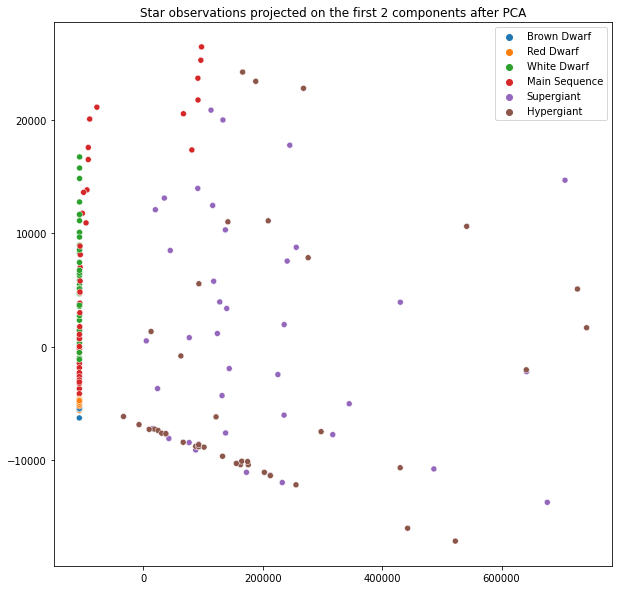

In [95]:
projected_stars = pca.fit_transform(X)

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=projected_stars[:,0], y=projected_stars[:,1], hue=labels)
plt.title("Star observations projected on the first 2 components after PCA")
plt.show()

Are we happy? Well, not so much: many stars are projected at the same x-axis coordinate and the remaining stars are not easy to separate in the 2D plane. However, we forgot something: **standardization**! Our various columns are expressed in different units which artifically distorts the amplitude of the numerical values. Let's use scikit-learn built-in scaler to center (mean=0) and normalize (std=1) the data.

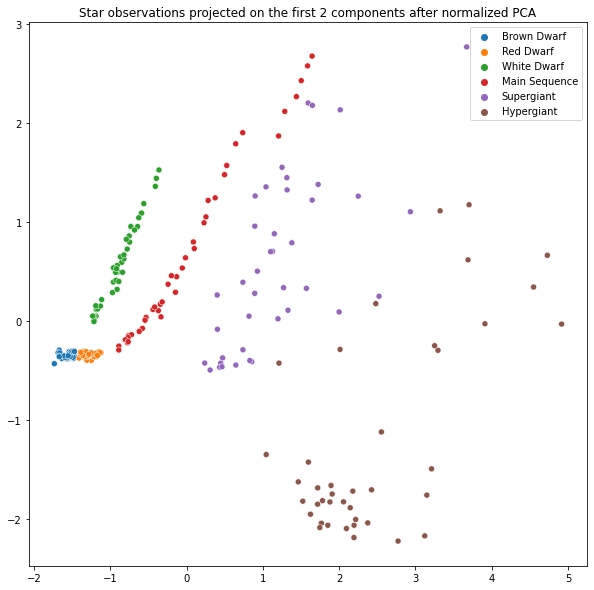

In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df_stars_data)

pca = PCA()
projected_stars = pca.fit_transform(X)

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=projected_stars[:,0], y=projected_stars[:,1], hue=labels)
plt.title("Star observations projected on the first 2 components after normalized PCA")
plt.show()

This is a lot better! In this point cloud, we can actually see some clusters emerge: stars of the same type tend to be projected around the same point in the 2D plane. This is encouraging since it means that our observations look like they are linearly separable (i.e. we can draw a line that separates each star type from all the others).

**Take away 1**: when dealing with a new dataset, data normalization or standardization often makes data mining easier. For linear models, rescaling is required when dealing with values expressed in different units.

PCA finds the linear combinations that explain most of the variance. We can check how much information we lost by keeping the first two components using the `explained_variance_ratio_` attribute:

In [97]:
s = 0
for idx, r in enumerate(pca.explained_variance_ratio_):
    s += r
    print(f"Component {idx+1} explains {100*r:.1f}% of the variance (cumulative = {100*s:.1f})")

Component 1 explains 60.4% of the variance (cumulative = 60.4)
Component 2 explains 23.5% of the variance (cumulative = 83.9)
Component 3 explains 9.3% of the variance (cumulative = 93.2)
Component 4 explains 6.8% of the variance (cumulative = 100.0)


Therefore the projection on the 2D plane explains 84% of the variance of the dataset. The visualization does not hide too much information so it gives a pretty faithul depiction of the dataset.

### Model selection : train/test split and cross-validation

After this preliminary analysis, we decide to keep all four features (temperature, magnitude, radius and luminosity). We will build a statistical model that infers the star type based on these values.

To evaluate how accurate our model will be, we split the dataset into two parts: the training set and the test set.

The training set is used to fit the statistical model. These are the examples that are used to "train" the model. We expect that the model will be very accurate on these data. But 100% accuracy on the training set is not necessarily a sign that the model is useful: memorization (or *overfitting*) can happen!

Therefore, we will evaluate the accuracy on the held-out test set. The samples from the test set were not seen during the training of the model. It will therefore measure how well the model **generalizes** to new data.

scikit-learn makes it very easy to divide a dataset into train and test, for example using the `train_test_split` function. For our example, let's use only 20% of the dataset as training samples.

In [98]:
from sklearn.model_selection import train_test_split
stars_train, stars_test = train_test_split(df_stars.drop(columns=["Star color", "Spectral Class"]), train_size=0.2)

We can now build four arrays: `X_*` will be the features (our input) and `y_*` will be our targets (the star types we want to predict).

In [99]:
X_train, y_train = stars_train.drop(columns="Star type"), stars_train["Star type"]
X_test, y_test = stars_test.drop(columns="Star type"), stars_test["Star type"]

### Decision tree

Decision trees are very common in machine learning. Their strong suit is their interpetability: it is easy to understand a posteriori why the model predicted type A instead of type B. Decision trees are implemented in `sklearn` in the `tree` module.

In [100]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

As before, we will use the `.fit()` method to train the statistical model. However, since decision trees are **supervised** models, we need not only to pass the data `X` as an argument, but also the **labels** `y`.

As you can see, we fit (*learn*) the model on the training pairs (data `X_train` and targets `y_train`).

In [101]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Done! We now have a decision tree. But is it any good? One way to evaluate our model is check its *accuracy* on our held-out test data. Accuracy is defined as `1 - #errors`. We can use the ``.predict()`` method to perform inference on an arbitrary sample.

In [102]:
tree.predict(X_test)

array([3, 5, 5, 2, 4, 5, 5, 0, 3, 3, 3, 3, 2, 2, 2, 3, 1, 5, 1, 1, 4, 1,
       5, 3, 4, 5, 3, 3, 5, 4, 4, 0, 3, 0, 1, 0, 1, 2, 3, 5, 0, 0, 1, 2,
       2, 1, 5, 2, 1, 2, 3, 4, 0, 3, 5, 1, 1, 4, 2, 2, 5, 4, 2, 0, 3, 0,
       4, 5, 2, 3, 4, 4, 2, 2, 4, 3, 2, 2, 3, 2, 2, 4, 0, 5, 0, 1, 1, 4,
       5, 3, 2, 5, 1, 2, 1, 5, 5, 3, 0, 0, 5, 5, 2, 2, 1, 2, 0, 5, 3, 2,
       5, 4, 5, 3, 5, 2, 0, 4, 4, 5, 5, 1, 1, 0, 0, 1, 5, 5, 1, 4, 5, 0,
       3, 1, 2, 0, 4, 0, 4, 5, 5, 0, 3, 4, 4, 1, 5, 1, 3, 4, 2, 1, 4, 3,
       0, 3, 1, 4, 5, 1, 0, 0, 2, 2, 2, 0, 5, 2, 3, 0, 0, 1, 0, 0, 3, 4,
       0, 4, 4, 3, 3, 1, 3, 3, 2, 3, 0, 1, 1, 3, 1, 5])

We could loop on all test samples and check whether the prediction matches the expected label. However, ``sklearn`` implements the convenient ``.score()`` function to do so, so let's use it:

In [103]:
tree.score(X_test, y_test)

0.9791666666666666

Great! Our model reaches over 90% accuracy on the test set. Well, the dataset is fairly easy. :-)

Knowing how many stars have been accurately classified is good but for a more detailed analysis, we can turn to the confusion matrix. The confusion matrix indicates for each actual star type (rows) how the stars of this group have been predicted (columns).

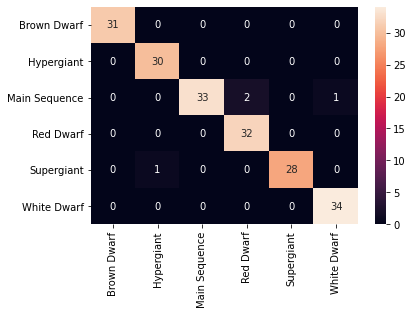

In [104]:
from sklearn.metrics import confusion_matrix

y_pred = tree.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.show()

We can now see that the 35 brown dwarves of the test dataset have all been correctly predicted as brown dwarves. However, 8 stars from the Main Sequence have been classified as Red Dwarfs.

As said before, one big advantage of decision trees is that they are easy to interpret. For example, you can draw the full decision tree to understand the different tests that are made before taking the final decision:

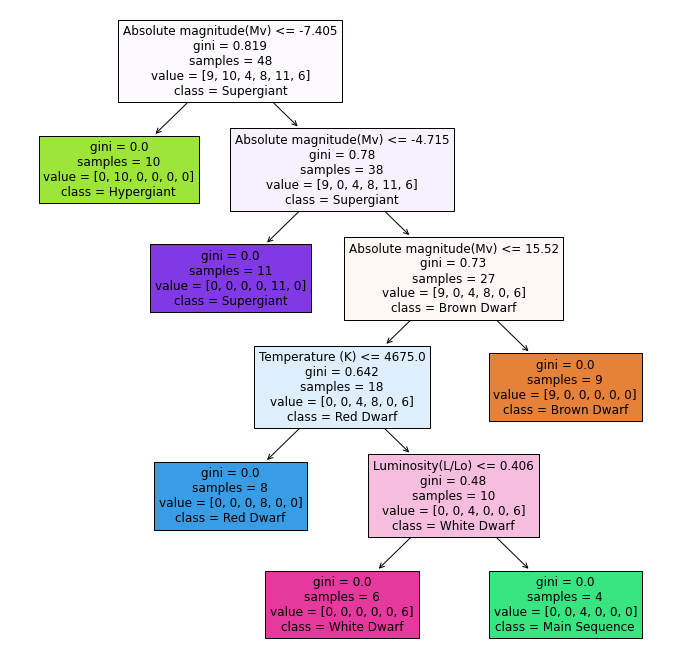

In [105]:
fig = plt.figure(figsize=(12, 12))
sklearn.tree.plot_tree(tree, filled=True, feature_names=stars_train.drop(columns="Star type").keys(), class_names=class_names)
plt.show()

### SVM

Now, decision trees are nice but they are fairly simple models. In the shallow ML world, Support Vector Machines (SVM) are all the rage. But do I have to rewrite all my code to use them? Nope! All models in scikit-learn have the same interface so you can just swap your ``DecisionTree`` with a ``SVC`` (Support Vector Classifier).

Check this out:

In [106]:
from sklearn.svm import SVC
scaler2 = StandardScaler()
X_train_s = scaler2.fit_transform(X_train)
X_test_s = scaler2.transform(X_test)
svm = SVC()
svm.fit(X_train_s, y_train)
svm.score(X_test_s, y_test)

0.7864583333333334

Great. However there is one little problem: the SVM is underperforming very badly the decision tree. Why? We let ``sklearn`` use the default parameters in the ``SVC()``. There are various parameters that you can use in an SVM. The two main ones are:

- the kernel (by default, scikit-learn uses a linear SVM, fast but not great. We often use a RBF kernel, slower but more powerful.)
- the regularization parameter ``C`` (it controls how "smooth" the decision border is).

So for example, I can ask for an SVM with a polynomial kernel of degree 4 and ``C=100`` using:

In [107]:
svm = SVC(C=100, kernel='poly', degree=4)
svm.fit(X_train_s, y_train)
svm.score(X_test_s, y_test)

0.9270833333333334

Much better. But you probably don't want to manually try all those values. Plus, if you try dozens of combinations and you check the score every time on the set, you are manually overfitting the test set. The hyperparameters that you find will be the best for your test set but many not the best for your future observations.

So the idea is to automatically explore several hyperparameters combinations (for example using a *grid search*). To avoid overfitting the test set, we will do cross-validation for each combination. scikit-learn conveniently offers a tool called ``GridSearchCV`` to this end and its interface is the same as all the other models!

In [108]:
from sklearn.model_selection import GridSearchCV

grid = {'C': [1e-2, 0.1, 1.0, 10, 100, 1000, 10000], 'kernel': ['linear', 'rbf'], 'gamma': ['auto', 'scale']}
model = GridSearchCV(SVC(), grid)
model.fit(X_train_s, y_train)
model.score(X_test_s, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.96875

Yay! We found an SVM that performs the same as our decision tree. We can print out its hyperparameters it we want to reuse them later.

In [109]:
model.best_params_

{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}

**Take away 2**: be rigourous when performing model evaluation. Use built-in ``sklearn`` tools for cross-validation and hyperparameter search. Don't tune hyperparameters on the test set!

## ML on image data

Let's move on to a harder problem. We have seen how to perform machine learning on tabular data, i.e. 1-dimensional data. Tabular data is often structured, meaning that the columns are known to be significant in a way or the other. The raw information has already been processed and synthesized in a catalogue.

But what if we want to go back the source? Computer vision provides a diverse set of tools taken from both image processing and machine learning that can help to perform data mining in large collections of image.

In [228]:
import urllib.request
urllib.request.urlretrieve("http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", "Galaxy10.h5")

('Galaxy10.h5', <http.client.HTTPMessage at 0x7fc00bfa8240>)

The dataset that we downloaded comes from the [`astroNN` package](https://astronn.readthedocs.io/en/latest/galaxy10.html). It is based on the [Galaxy Zoo collection](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) which itself uses images from the Sloan Digital Sky Survey (SDSS). Let's check out what the images look like.

In [111]:
import numpy as np
import h5py

# Images and labels are stored in HDF5 format but we could use flat files instead
with h5py.File('Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'], dtype='int64')

print(f"Galaxy10 dataset: {len(images)} images and {len(np.unique(labels))} classes")

Galaxy10 dataset: 21785 images and 10 classes


We are dealing with 69x69 color images of galaxies. The goal of the Galaxy10 dataset is perform classification of these images into one of the 10 galaxy shapes defined hereafter:

In [112]:
class_names = [
    "Disk, Face-on, No Spiral",
    "Smooth, Completely round",
    "Smooth, in-between round",
    "Smooth, Cigar shaped",
    "Disk, Edge-on, Rounded Bulge",
    "Disk, Edge-on, Boxy Bulge",
    "Disk, Edge-on, No Bulge",
    "Disk, Face-on, Tight Spiral",
    "Disk, Face-on, Medium Spiral",
    "Disk, Face-on, Loose Spiral"
]

We can display using Matplotlib one example of each class:

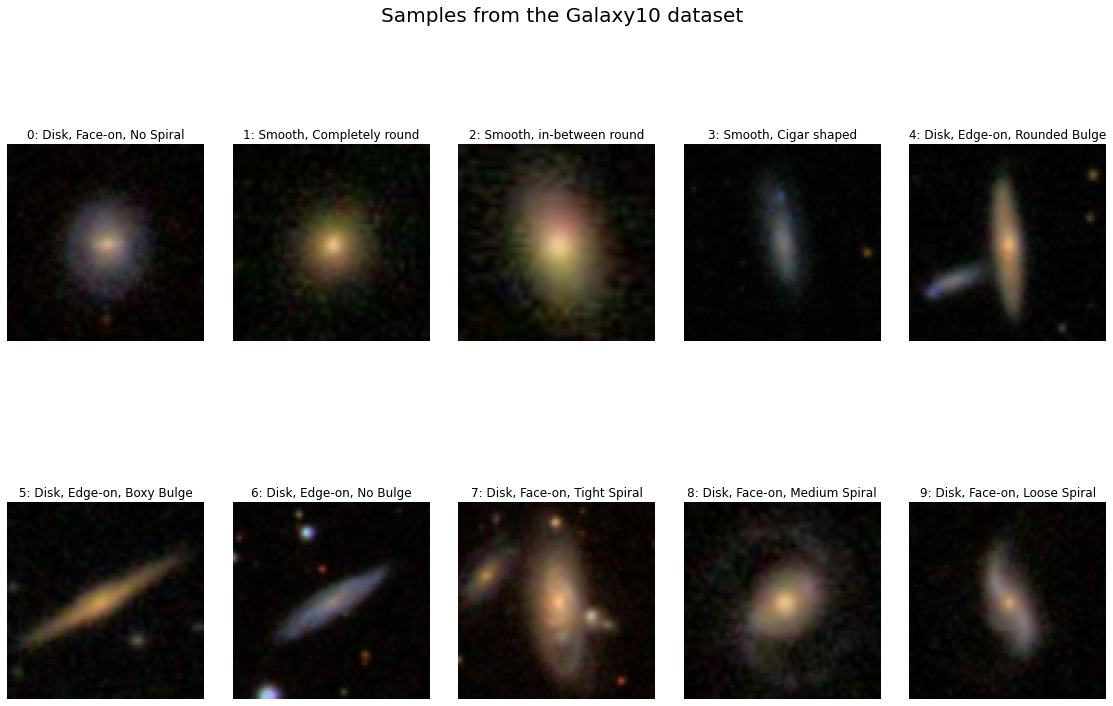

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

_, demo_idx = np.unique(labels, return_index=True)

fig = plt.figure(figsize=(16, 12))
for idx, (img, label) in enumerate(zip(images[demo_idx], labels[demo_idx])):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label}: {class_names[label]}")
fig.tight_layout(h_pad=0, w_pad=0)
plt.suptitle("Samples from the Galaxy10 dataset", fontsize=20)
plt.show()

As usual, we will split the dataset in two. In this case, we will use 60% of the images for training and the remaining 40% for test.

In [114]:
from sklearn.model_selection import train_test_split
images_train, images_test, y_train, y_test = train_test_split(images.astype('float32'), labels, train_size=0.6)

### Standard image features

When working with images, the standard approach for object recognition was to use so-called feature descriptors. These descriptors are a way to describe some properties of the image in a compressed vector with a smaller dimension than the full image matrix. Examples of such descriptors are the [wavelet decomposition](https://en.wikipedia.org/wiki/Discrete_wavelet_transform#Example_in_image_processing) or [color histograms](https://en.wikipedia.org/wiki/Color_histogram).

These descriptors are then used instead of the image as features for ML models. This section illustrates how to apply this pipeline on the Galaxy10 dataset.

#### HOG + SVM

Histogram of Oriented Gradients (HOG) is a classical feature descriptor for images. It is very popular in computer vision for object detection and classification. The core idea is that the image will be divided in blocks. On each block, gradients will be computed for different orientations.

The HOG algorithm was introduced by [Navneet Dalal and Bill Triggs in 2005 for pedestrian detection](https://hal.inria.fr/inria-00548512/document).

The `scikit-image` library has built-in support for HOG. A common pipeline for image classification is the so-called HOG+SVM pipeline. It is comprised of two steps:
1. extract HOG from all images (this produces a 1D feature vector for all images)
2. train a SVM on the HOG features

In [115]:
from skimage.feature import hog
from tqdm.notebook import tqdm

def hog_galaxy10(image):
    # Compute the Histogram of Oriented Gradients on an image
    # We use 8 orientations and 8 pixels in a cell/block
    return hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1,1), multichannel=True)

# Extract HOG on the training and testing images.
# This will take a few seconds.
X_train = np.array([hog_galaxy10(image) for image in tqdm(images_train, desc="HOG on train")], dtype='float32')
X_test = np.array([hog_galaxy10(image) for image in tqdm(images_test, desc="HOG on test")], dtype='float32')

As an example, we can produce a 2D visualization of what the HOG "sees" in the image.

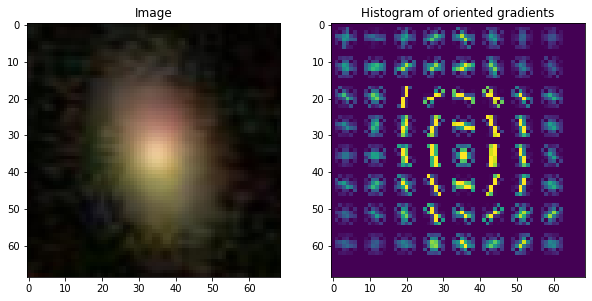

In [116]:
from skimage import data, exposure

feat, hog_image = hog(images[0], orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1,1), multichannel=True, visualize=True)

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(121)
plt.imshow(images[0])
plt.title("Image")
fig.add_subplot(122)
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image)
plt.title("Histogram of oriented gradients")
plt.show()

In [117]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=2000)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6045444112921735

**Takeaway 3**: you don't always need deep learning. Always use a simple baseline to ensure that your deep network actually performs better.

#### HOG + Neural networks

Some neural networks can be used as drop-in replacements for traditional ML models. Actually, simple neural networks have been used since the 60s. Although `sklearn` implements some basic neural networks (called the Multilayer Perceptron or MLP), we are not going to use it since it does not support GPU acceleration. Instead, we are going to use the PyTorch tensor computing library.

In their core, PyTorch and Tensorflow are generic tensor computing libraries (similar to NumPy) that support GPU acceleration for faster computing. However, those libraries have been designed with deep learning in mind which means that they also support automatic differentiation (required to train neural networks using backpropagation) and expose useful functions to define neural networks.

We will start by importing the torch library and the skorch wrapper. As we will see, `skorch` is wrapper around torch that transforms neural networks defined with torch into Python objects that follow the same interface as scikit-learn models. This makes it very easy to work move from shallow ML to deep learning.

In [118]:
import torch
import skorch
# For reproducibility purposes, we set the random number generator seed manually.
torch.manual_seed(0)

Neural networks can be computationally expensive. To reduce the compute time, we can use accelerators such as Graphical Processing Units (GPU). Originally designed for 3D rendering and gaming, GPUs are very effective for parallel matrix multiplication.

The next code cell checks if an NVIDIA GPU supporting CUDA acceleration is available. If not, the torch code will execute on CPU (and it will be around 10x slower).

In [119]:
# Check if GPU is available, fallback on CPU if not
device = 'cuda' if torch.cuda.is_available else 'cpu'

Let's define a simple neural network. Building neural networks can sometimes look like LEGO, where you stack layers of predefined functions.

The most basic layer is the `Linear` (or *fully connected* layer). It takes as an input a vector $X \in \mathbb{R}^p$ and produces a vector $Z \in \mathbb{R}^q$. Fundamentally, this is a matrix multiplication :
$Z = W.X + b$

All neurons (values) from $X$ are connected to every neuron of $Z$. The weights $w_{i,j}$ of the matrix $W$ define the weight of the $p \times q$ synaptic connections. $b$ is a constant bias vector $\in \mathbb{R}^q$.

**Caveat**: $W$ can become very large (more than 1 million parameters) when $p$ and $q$ grow.

The `Linear` layer is actually the most basic neural network than you can imagine. In the 60s, it was called the  [Perceptron](https://en.wikipedia.org/wiki/Perceptron). In the Perceptrons book (1969), Marvin Minsky and Seymour Papert noted that, because the relation between $Z$ and $X$ is linear, the Perceptron has a very limited capacity (for example a Perceptron cannot approximate the XOR function).

But what if we added more layers? Well, $Z = W_1 . W_2 . W_3 . X$ is still a single linear matrix multiplication. The trick is to add **non-linearities** between the layers.

Vaguely similar to what happens in biological neurons, we will now say that the output of a neuron is the sum of its weighted inputs **passed through an non-linear activation function**. Any differentiable non-linear function will do but most often, we use the ReLU activation from [Glorot et al., 2011](http://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf).

$$ReLU: x \rightarrow max(0, x)$$

We can now define a non-linear MultiLayer Perceptron (MLP). There are multiple ways to define a neural network in PyTorch. For simple models, the fastest approach is to use the `Sequential` API.

In [120]:
from torch import nn

mlp = nn.Sequential(
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10)
)

`mlp` now defines a `torch` neural network object. Using `skorch`, we will define an estimator similar to the previous objets we used in scikit-learn:

In [121]:
nn_classifier = skorch.classifier.NeuralNetClassifier(mlp,
                                                      lr=0.05, # Learning rate
                                                      max_epochs=50, # Number of epochs
                                                      criterion=nn.CrossEntropyLoss, # Loss function
                                                      device=device) # Execute on GPU or CPU

We give to `skorch` some hyperparameters, namely:
- the loss function that we want to minimize. In our case, we use the cross entropy loss which is the most common for classification.
- the learning rate, which defines the amplitude of the step in the gradient descent training algorithm.
- the `max_epochs` parameters which defines how long the network will be trained. With `max_epochs=20`, the model will see every sample in the training dataset 20 times.

Now that we defined our neural network using `skorch`, we can use the `fit` and `score` methods as before.

In [122]:
nn_classifier.fit(X_train, y_train)
nn_classifier.score(X_test, y_test)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8454       0.3178        1.7389  0.2424
      2        1.7211       0.3178        1.7050  0.2363
      3        1.6725       0.3178        1.6324  0.2412
      4        1.5854       0.3526        1.5538  0.2344
      5        1.5182       0.3533        1.5755  0.2336
      6        1.4891       0.3595        1.5704  0.2449
      7        1.4639       0.3656        1.5681  0.2359
      8        1.4424       0.3686        1.5679  0.2370
      9        1.4238       0.3728        1.5724  0.2314
     10        1.4055       0.3824        1.5644  0.2346
     11        1.3824       0.4011        1.4804  0.2286
     12        1.3539       0.4298        1.4133  0.2449
     13        1.3343       0.4436        1.4027  0.2416
     14        1.3069       0.4704        1.3398  0.2338
     15        1.2784       0.4818        1.3301  0.2293
     16        1.2445       0.4

0.6848749139316043

Done! We now have trained our first neural network. At first glance, it performs significantly better on the HOG features than the SVM baseline (but remember that we did not fine-tune the SVM hyperparameters so it is a pessimistic baseline).

**Takeaway 4**: `skorch` allows you to use deep neural networks in the same way as scikit-learn models.

We can plot both confusion matrices to compare the models.

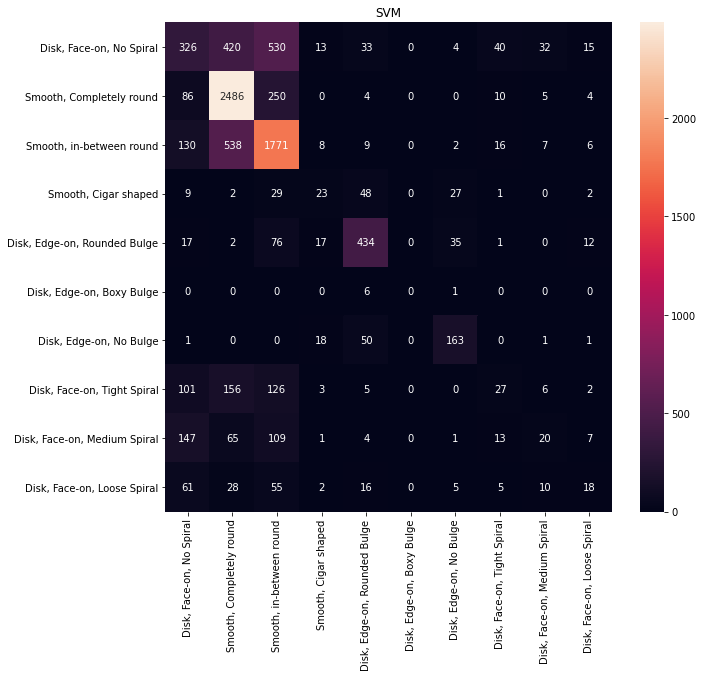

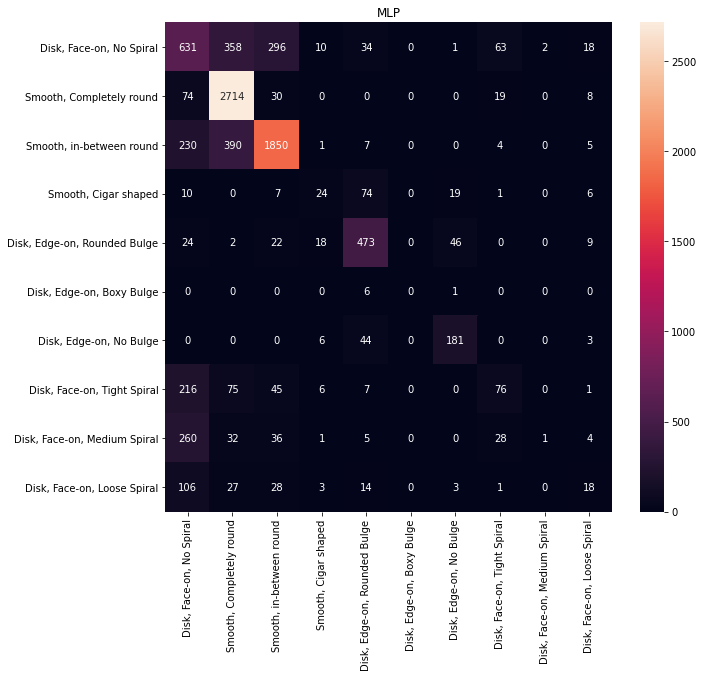

In [123]:
import sklearn

def show_G10_results(y_pred, y_test, title=None):
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 9))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names )
    if title is not None:
        plt.title(title)
    plt.show()

show_G10_results(svm.predict(X_test), y_test, title="SVM")
show_G10_results(nn_classifier.predict(X_test), y_test, title="MLP")

### Convolutional Neural Networks

The current state of the art for image classification is the Convolutional Neural Network (CNN). The fundamentals of this architecture were introduced by [Yann Lecun et al. in 1998](http://yann.lecun.com/exdb/lenet/) for written character recognition.

The idea underlying the CNN is that fully connected networks are unefficient for image data since the input vector would be very large (a 69x69x3 image = 14283 input values). A hidden layer with even a moderate amount of neurons would become huge (with 500 neurons, this results in more than 7 million parameters).

Convolutional kernels can shared and used for all pixels in the image. We can perform multiple convolutions on the image to obtain various filtering results. Then, we can apply a non-linear activation (same as in the MLP) and stack a new set of convolutions.

This stack of alternated convolutions and non-linearities forms the basics of CNN.

First, we transpose the image from the HxWxC format (*channels last*) to the CxHxW format (*channels first*). Most deep learning frameworks, such as PyTorch, use the latter.

In [124]:
images_train = images_train.transpose(0, 3, 1, 2)
images_test = images_test.transpose(0, 3, 1, 2)

In [125]:
from torch import nn

cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, 10)
)

cnn_classifier = skorch.classifier.NeuralNetClassifier(cnn,
                                                       lr=0.005,
                                                       optimizer__momentum=0.9,
                                                       max_epochs=20,
                                                       criterion=nn.CrossEntropyLoss,
                                                       device=device)
cnn_classifier.fit(images_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7642       0.3338        1.5600  4.1388
      2        1.5240       0.4317        1.3614  4.1216
      3        1.3546       0.4344        1.3631  4.1220
      4        1.2895       0.4891        1.2234  4.1174
      5        1.1571       0.4887        1.1712  4.1204
      6        1.0573       0.5530        1.1093  4.1371
      7        0.9923       0.5533        1.0862  4.1240
      8        0.8541       0.6554        0.8656  4.1199
      9        0.7964       0.7522        0.7054  4.1087
     10        0.7372       0.6447        0.9230  4.1351
     11        0.7266       0.7331        0.7233  4.1375
     12        0.6632       0.7644        0.6575  4.1350
     13        0.6503       0.7618        0.6756  4.1160
     14        0.6216       0.7568        0.6703  4.1143
     15        0.5803       0.7790        0.6372  4.1189
     16        0.5432       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): AdaptiveAvgPool2d(output_size=(1, 1))
    (14): Flatten()
    (15): Linear(in_feat

To test the network, we can do a forward pass on a sample image. For example, let's take image #174 from the test set and move it through the network:

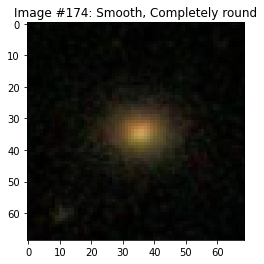

Input image tensor has dimensions torch.Size([1, 3, 69, 69])
The output is a vector of size torch.Size([1, 10])
tensor([[ 5.2098, 11.2177,  9.7421, -5.3495,  0.0521, -6.2909, -8.2975, -2.9495,
         -0.8125, -0.9364]], device='cuda:0')


In [133]:
idx = 174
img = images_test[idx]
label = y_test[idx]

plt.imshow(img.astype('uint8').transpose((1, 2, 0))) and plt.title(f"Image #{idx}: {class_names[label]}") and plt.show()

img_tensor = torch.from_numpy(img).unsqueeze(0) # add 4th dimension along first axis
print(f"Input image tensor has dimensions {img_tensor.size()}")
with torch.no_grad(): # This deactivates the gradient computation (runs faster)
  output = cnn(img_tensor.to(device))
print(f"The output is a vector of size {output.size()}")
print(output)

The output vector has as many values as there are classes. The activation $i$ indicates how much the neuron corresponding to class $i$ has been excited. We can use the argmax operator to get the index of the class predicted by the model. We can get the ranked classes based on their activation :

In [136]:
class_idx = torch.argmax(output[0])
print(f"Predicted class is: {class_idx} ({class_names[class_idx]})")
sorted_classes = np.argsort(-output[0].cpu().numpy()) # argsort by decreasing value
print(f"Other predictions were {[class_names[c] for c in sorted_classes]}")

Predicted class is: 1 (Smooth, Completely round)
Other predictions were ['Smooth, Completely round', 'Smooth, in-between round', 'Disk, Face-on, No Spiral', 'Disk, Edge-on, Rounded Bulge', 'Disk, Face-on, Medium Spiral', 'Disk, Face-on, Loose Spiral', 'Disk, Face-on, Tight Spiral', 'Smooth, Cigar shaped', 'Disk, Edge-on, Boxy Bulge', 'Disk, Edge-on, No Bulge']


Like scikit-learn, `skorch` provides a built-in scoring function so that we don't need to loop over all test samples manually:

In [139]:
accuracy = cnn_classifier.score(images_test, y_test)
print(f"CNN accuracy is {100*accuracy:.2f}%")

CNN accuracy is 75.63%


Using the `predict` method, we can once again get the predictions to build the confusion matrix.

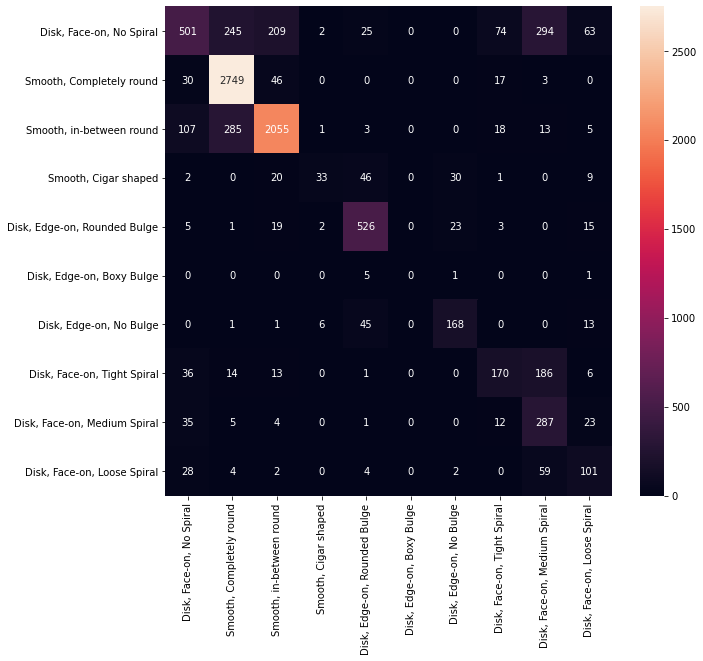

In [141]:
y_pred = cnn_classifier.predict(images_test)
show_G10_results(y_pred, y_test)

Note that the confusion matrix is not to only way to evaluate a classification. Accuracy is not always the best metric, especially when data is unbalanced. We often used precision and recall as additional metrics (also known as precision and sensitivity):

$\text{precision} = \frac{\text{true positives}}{\text{true positives} + \text{true negatives}}$

$\text{recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$

These metrics can be consolidated into the $F_1$ score, which is their harmonic mean:
$F_1 = \frac{2 TP}{2TP + FP + FN}$

In [143]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, labels=range(0,10), target_names=class_names, zero_division=0))

                              precision    recall  f1-score   support

    Disk, Face-on, No Spiral       0.67      0.35      0.46      1413
    Smooth, Completely round       0.83      0.97      0.89      2845
    Smooth, in-between round       0.87      0.83      0.85      2487
        Smooth, Cigar shaped       0.75      0.23      0.36       141
Disk, Edge-on, Rounded Bulge       0.80      0.89      0.84       594
   Disk, Edge-on, Boxy Bulge       0.00      0.00      0.00         7
     Disk, Edge-on, No Bulge       0.75      0.72      0.73       234
 Disk, Face-on, Tight Spiral       0.58      0.40      0.47       426
Disk, Face-on, Medium Spiral       0.34      0.78      0.47       367
 Disk, Face-on, Loose Spiral       0.43      0.51      0.46       200

                    accuracy                           0.76      8714
                   macro avg       0.60      0.57      0.55      8714
                weighted avg       0.77      0.76      0.75      8714



### Working with PyTorch

`skorch` is a useful wrapper around PyTorch that is compatible with scikit-learn. However, it does not allow the same fine control on what is going on than working directly with `torch`. Let's look at how to do the same thing but without skorch. This will also help us understand a little bit more what is going on when training the neural network.

We already defined the neural network. We could have used the subclass API to define our own module but, since the CNN we are using is relatively simple, we will keep the Sequential model we defined previously.

To work directly with PyTorch, we need to define a torch-compatible Dataset object. The Dataset details how the data is loaded into memory. Since we already loaded the data in the HDF5 format, we can use the `TensorDataset` tool.

In [144]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(torch.from_numpy(images_train), torch.from_numpy(y_train))
test_ds = TensorDataset(torch.from_numpy(images_test), torch.from_numpy(y_test))

The core functionality of the Datasets is that they are iterable objects that return (sample, label) pairs:

In [145]:
for img, label in train_ds:
    print(f"Image: {img.size()}")
    print(f"Label: {label}")
    break

Image: torch.Size([3, 69, 69])
Label: 8


The gradient descent of deep networks is done in batches. Sampling batches of examples from the dataset is the job of the `DataLoader`:

In [146]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=0)

We can now define a training function that takes a network and a DataLoader and perform the gradient descent training:

In [147]:
def train(network, dataloader, epochs=10, lr=0.01, device=device):
    # Move the network to GPU if required
    network = network.to(device)
    
    # Define the optimization algorithm (here, Stochastic Gradient Descent with momentum)
    optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9)
    
    # Define the loss function (in our case, cross-entropy)
    criterion = torch.nn.CrossEntropyLoss()
    
    for e in tqdm(range(epochs), total=epochs): # One epoch = one pass on the whole dataloader
        # This puts the neural network into "training mode"
        network.train()

        # For each batch of examples, do one step of the gradient
        for batch, label in tqdm(dataloader, desc=f"Epoch {e+1}/{epochs}", leave=False):
            # Reset gradient values
            optimizer.zero_grad()
            
            # Move Tensors into CPU or GPU memory
            batch, label = batch.to(device), label.to(device)
            
            # Forward pass (get predictions from the network)
            output = network(batch)
            # Compute the error between predictions and true labels
            loss = criterion(output, label)
            # Compute the gradients (backward pass)
            loss.backward()
            
            # Update the weights (= one step of gradient descent)
            optimizer.step()
    
    return network        

In [148]:
cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, 10)
)

train(cnn, train_loader, lr=0.005, epochs=50)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): ReLU()
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): AdaptiveAvgPool2d(output_size=(1, 1))
  (14): Flatten()
  (15): Linear(in_features=256, out_features=10, bias=True)
)

In [149]:
from sklearn.metrics import accuracy_score

def val(network, dataloader, device=device):
    criterion = torch.nn.CrossEntropyLoss()
    
    network = network.to(device)
    predictions = []
    labels = []
    loss = 0.
    
    with torch.no_grad():
        for batch, label in tqdm(dataloader):
            batch, label = batch.to(device), label.to(device)
            output = network(batch)
            loss += criterion(output, label)
            labels.append(label.cpu().numpy())
            predictions.append(torch.argmax(output, dim=1).cpu().numpy())
            
    print(f"Average loss: {loss/len(labels)}")
    labels, predictions = np.concatenate(labels), np.concatenate(predictions)
    print(f"Accuracy: {accuracy_score(labels, predictions)}")
    return predictions

In [53]:
val(cnn, test_loader)


Average loss: 1.2879701852798462
Accuracy: 0.8107642873536838


array([0, 3, 2, ..., 1, 1, 1])

**Note :** due to some subtleties in how `skorch` handles the training, this result is not directly comparable to the CNN trained with skorch. Both accuracies should however be in the same ballpark, $\pm$ a few percents.

### Data augmentation

Data augmentation is used to produce new training samples from the existing ones. For example, we know that flipping an image of a galaxy does not change the galaxy type -- we say the galaxy classification task is invariant to symetry. Therefore, for a single image, we know that its flipped and mirrored versions are acceptable images of the same class:

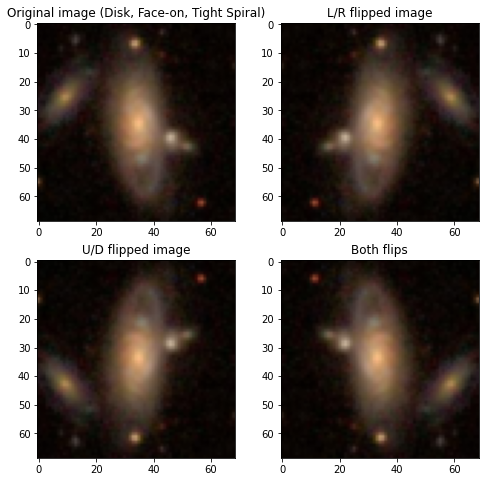

In [150]:
fig = plt.figure(figsize=(8,8))
img, l = images[9], class_names[labels[9]]
fig.add_subplot(221)
plt.imshow(img)
plt.title(f"Original image ({l})")
mirror = np.fliplr(img)
fig.add_subplot(222)
plt.imshow(mirror)
plt.title("L/R flipped image")
flip = np.flipud(img)
fig.add_subplot(223)
plt.imshow(flip)
plt.title("U/D flipped image")
both = np.fliplr(flip)
fig.add_subplot(224)
plt.imshow(both)
plt.title("Both flips")
plt.show()

To achieve on-the-fly data augmentation, we need to define a custom `Dataset` in PyTorch. Fortunately for us, this is not too hard: we mostly need to define an iterator subclassing `Dataset` that supports the `__getitem__()` method. See the code below:

In [151]:
from torch.utils.data import Dataset

class Galaxy10Dataset(Dataset):
    def __init__(self, data, targets, transform=None):
        super(Galaxy10Dataset, self).__init__()
        
        assert(len(data) == len(targets))
        self.data = data.astype('uint8')
        self.targets = targets
        self.transform = transform
    
    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]
        
        if self.transform is not None:
            img = 255 * self.transform(img)
        return img, target

    def __len__(self):
        return len(self.data)

Everytime we will query the dataset object for an image, it will apply the `transform` function on it.

`torchvision` provides some common image transformations that we can reuse. Our overall transformation is composed of four steps:
1. We convert the image array to PIL format for easier manipulation,
2. Horizontal flip the image with probability p=0.5,
3. Vertical flip the image with probability p=0.5,
4. Extract a random 64x64 crop from the image (simulate random translations),
5. Convert PIL image back to Tensor.

In [152]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomCrop((64, 64)),
    transforms.ToTensor()
])

As an example, we can manually apply the `transform` object in a sample image to test its effect. Repeat this cell several time to see the image on the right change depending on the random transformations.

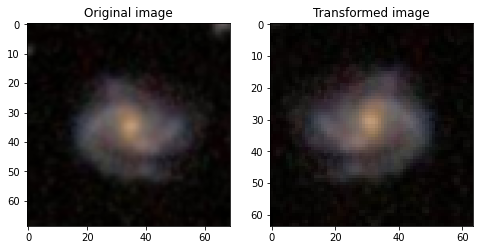

In [153]:
image = images_train[0].astype('uint8').transpose((1, 2, 0))
transformed_image = transform(image)
fig = plt.figure(figsize=(8,8))
fig.add_subplot(121)
plt.title("Original image")
plt.imshow(image)
fig.add_subplot(122)
plt.title("Transformed image")
plt.imshow(transformed_image.numpy().transpose((1, 2, 0))) and plt.show()

Now, we can finally build a training dataset and the corresponding `DataLoader` that will use the training images and randomly apply data augmentation to them.

In [154]:
train_augmented_ds = Galaxy10Dataset(images_train.transpose((0, 2, 3, 1)), y_train, transform=transform)

train_augmented_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)

By including new images corresponding to both mirroring and flipping, we virtually multiply by 3 the size of the training set. This often results in better generalization and higher accuracy.

In [155]:
cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, 10)
)

train(cnn, train_augmented_loader, lr=0.005, epochs=50)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): ReLU()
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): AdaptiveAvgPool2d(output_size=(1, 1))
  (14): Flatten()
  (15): Linear(in_features=256, out_features=10, bias=True)
)

In [156]:
y_pred = val(cnn, test_loader)


Average loss: 1.2581462860107422
Accuracy: 0.8138627495983475


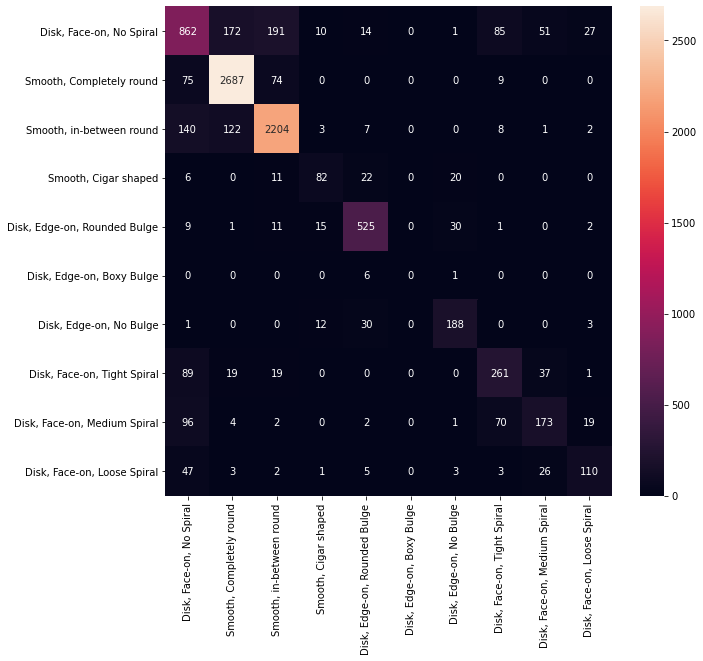

In [157]:
show_G10_results(y_pred, y_test)

**Takeaway 5**: more data always beat a clever algorithm. When you can, use data augmentation to increase the size of your dataset.

### Fine-tuning

One of the strength of deep learning toolboxes is that many state of the art models have already been implemented. For example, using the `torchvision` library, it is straightforward to reuse the deep residual network architecture (**ResNet**) developed by [Kaiming He et al. in 2015](http://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf).

In [158]:
from torchvision.models import resnet18, resnet34, resnet50

resnet = resnet18()

cnn_classifier = skorch.classifier.NeuralNetClassifier(resnet,
                                                       lr=0.01,
                                                       optimizer__momentum=0.9,
                                                       max_epochs=50,
                                                       criterion=nn.CrossEntropyLoss,
                                                       device=device)
cnn_classifier.fit(images_train, y_train)
cnn_classifier.score(images_test, y_test)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5792       0.6229        1.1074  4.5650
      2        0.8849       0.5690        1.1564  4.5660
      3        0.7444       0.6837        0.8790  4.5688
      4        0.6769       0.6428        0.9337  4.5477
      5        0.5992       0.6585        1.5975  4.5553
      6        0.5584       0.6983        1.2813  4.5659
      7        0.5034       0.6662        0.9975  4.5629
      8        0.4524       0.7101        0.9304  4.5624
      9        0.4037       0.7033        0.9795  4.5730
     10        0.3531       0.5969        1.9433  4.5752
     11        0.3294       0.6512        1.3859  4.5571
     12        0.3111       0.6023        2.1482  4.5352
     13        0.2758       0.7136        1.1498  4.5567
     14        0.2531       0.4558        2.0206  4.5563
     15        0.2361       0.2811        3.7411  4.5496
     16        0.2227       0.6

0.786550378700941

What's even better is that most models have been already trained for image classification on [ImageNet](http://www.image-net.org/). ImageNet contains 1 million images for 1,000 object classes, ranging from phones and chairs to cats and dogs. Of course, the models trained on ImageNet cannot be directly used for galaxy classification.

However, we can **fine-tuning** to leverage what the model has learnt for generic image classification on ImageNet and specialize it on the Galaxy10 dataset.

For example, we can load the weights of the model pretrained on ImageNet and use those as a starting point to train the network on Galaxy10. This generally results in faster training (since the network already knows a lot about image classification) and the model often performs better.

In [159]:
from torchvision.models import resnet18, resnet34, resnet50

# pretrained=True will load the model with weights obtained by training on ImageNet
resnet = resnet18(pretrained=True)

cnn_classifier = skorch.classifier.NeuralNetClassifier(resnet,
                                                       lr=1e-4, # lower learning rate
                                                       optimizer__momentum=0.99,
                                                       max_epochs=10, # only 10 epochs instead of 50
                                                       criterion=nn.CrossEntropyLoss,
                                                       device=device)
cnn_classifier.fit(images_train, y_train)
cnn_classifier.score(images_test, y_test)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        5.4508       0.5663        1.5662  4.5983
      2        1.0734       0.6902        0.8254  4.5956
      3        0.6757       0.7556        0.6629  4.5761
      4        0.5378       0.7874        0.6200  4.5820
      5        0.4550       0.7966        0.5650  4.5823
      6        0.3962       0.8119        0.5472  4.6000
      7        0.3471       0.7893        0.6080  4.5888
      8        0.2919       0.7874        0.6330  4.5990
      9        0.2417       0.7855        0.6590  4.6057
     10        0.2114       0.7851        0.6537  4.6000


0.786779894422768

We reached a similar accuracy but in less epochs. The pretrained weights gave this model a head start for training.

**Takeaway 6**: use pretrained models when they exist for faster training and better generalization (in most cases). For image classification, there are many SOTA pretrained models available online.

Using this idea, we can efficiently leverage large models even with limited computational power. For example, we can train a large DenseNet model in a few epochs:

In [160]:
from torchvision.models import densenet121

# pretrained=True will load the model with weights obtained by training on ImageNet
densenet = densenet121(pretrained=True)

cnn_classifier = skorch.classifier.NeuralNetClassifier(densenet,
                                                       lr=1e-4, # lower learning rate
                                                       optimizer__momentum=0.99,
                                                       max_epochs=6, # only 6 epochs
                                                       criterion=nn.CrossEntropyLoss,
                                                       device=device)
cnn_classifier.fit(images_train, y_train)
cnn_classifier.score(images_test, y_test)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        5.7743       0.6084        2.0950  10.8545
      2        1.0218       0.7503        0.7607  10.8717
      3        0.6512       0.7633        0.6465  10.8519
      4        0.5135       0.8054        0.5341  10.8600
      5        0.4353       0.8157        0.5073  10.8720
      6        0.3652       0.8203        0.5031  10.8602


0.8187973376176269

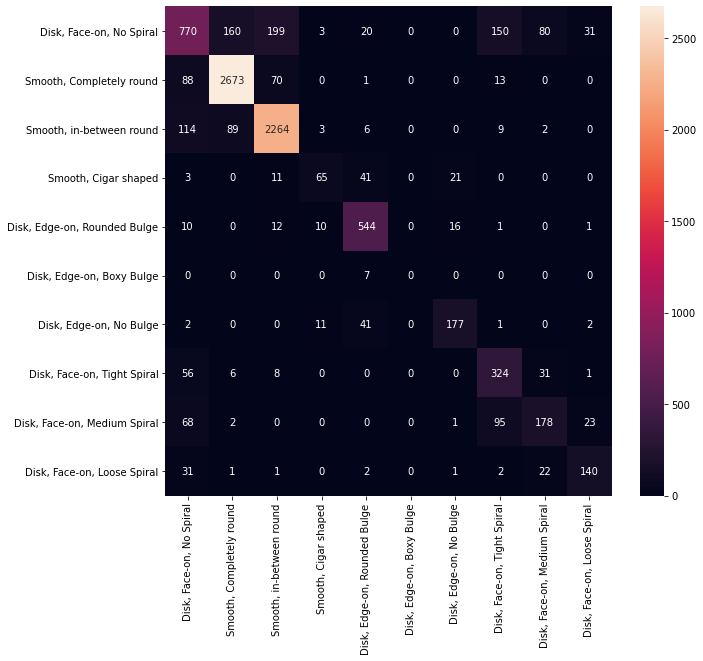

In [223]:
show_G10_results(cnn_classifier.predict(images_test), y_test)

### Playing with deep features

The internal representations that neural networks build can be used as very effective descriptors for clustering and data mining. For example, this block will demonstrate how to extract intermediate activations (*features*) from the CNN trained on Galaxy10 to use for image retrieval and 2D visualization.

To start, we need to extract features for all the images from our dataset. We write a short helper function to achieve this.

In [174]:
feat_extractor = nn.Sequential(*list(cnn_classifier.module.children())[0][:-1])

def extract_features(network, dataset, batch_size=128, transpose=True, device='cpu'):
    bs = batch_size
    network = network.to(device)
    features = np.zeros((len(dataset), 1024), dtype='float32')
    with torch.no_grad():
        for idx in tqdm(range(len(dataset) // bs)):
            data = dataset[idx*bs:idx*bs+bs]
            if transpose:
                data = data.transpose((0, 3, 1, 2))
            batch = torch.from_numpy(data).to(device)
            features[idx*bs:idx*bs+bs] = network(batch).cpu().numpy().mean(axis=(2,3))
    return features

train_features = extract_features(feat_extractor, images_train, transpose=False, device=device)
test_features = extract_features(feat_extractor, images_test, transpose=False, device=device)

#### Finding similar images

For each image in the dataset, we now have a 1024-vector that describes it. By itself, this vector is not very useful.

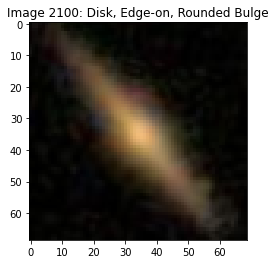

In [188]:
i = 2100
plt.imshow(images_test[i].transpose((1, 2, 0)).astype('uint8'))
plt.title(f"Image {i}: {class_names[y_test[i]]}")
plt.show()

If we consider that this vector represents a point in an Euclidean space of dimension 1024, we could for its nearest neighbours.

Let's find the 4 nearest neighbours of this image in our dataset.

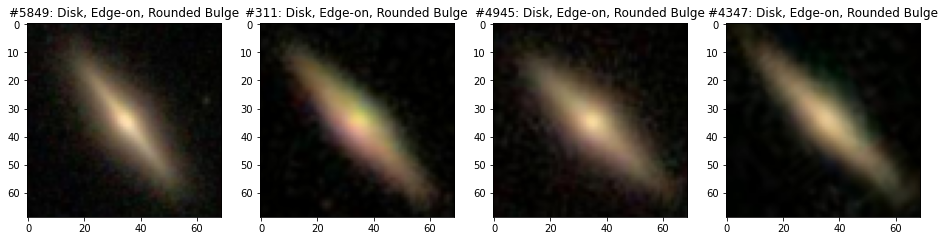

In [206]:
def find_closest_image(query, features):
    distances = [np.linalg.norm(query - f) for f in features]
    return np.argsort(distances)

nearest = find_closest_image(test_features[i], test_features)
fig = plt.figure(figsize=(16, 8))
for idx, i in enumerate(nearest[1:5]):
    fig.add_subplot(1,4,idx+1)
    plt.imshow(images_test[i].transpose((1, 2, 0)).astype('uint8'))
    plt.title(f"#{i}: {class_names[y_test[i]]}")
plt.show()

Nice! This function returned images that visually quite similar to to our "query" image. This can be very useful to detect near-duplicates or to find images that look like other things.

#### Visualizing the image space

If you remember, in the beginning of this notebook we used PCA as dimension reduction algorithm. Why not use the same approach as we did before to project our deep feature vectors in a 2D space so that we can visualize our data using a point cloud?

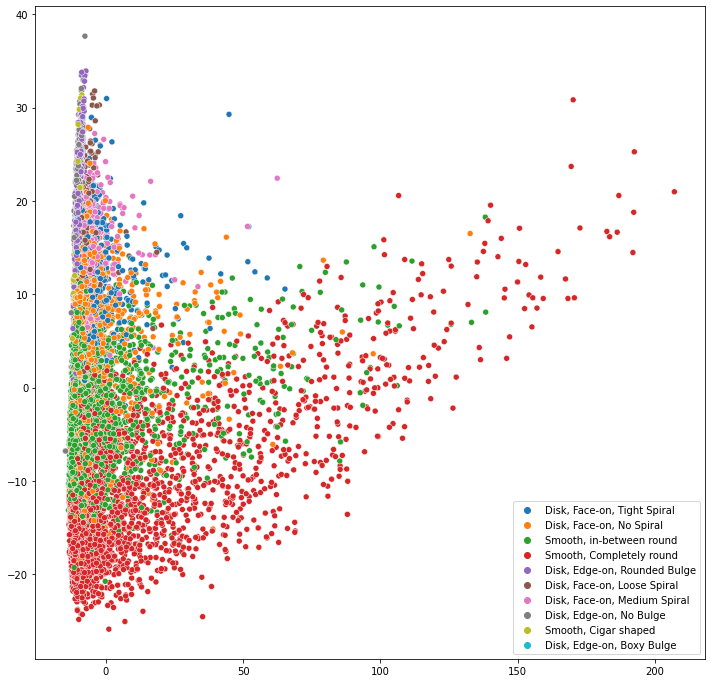

In [211]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])
X = pipeline.fit_transform(test_features)
fig = plt.figure(figsize=(12, 12))
sns.scatterplot(x=X[:,0], y=X[:, 1], hue=np.array([class_names[y] for y in y_test]))
plt.show()

It's working. We can now understand a little bit better how the network "sees" the images. Some types of galaxies have been clustered around the same point while others are strangely quite far from other supposedly similar images. Maybe these images are outliers because of sensor noise/artifacts or because the objects are weird.

However, PCA is not very effective on deep features because the activations are probably not linearly correlated. There are more powerful dimension reduction techniques that perform non-linear disentanglement such t-SNE and UMAP.

t-SNE is implemented in scikit-learn so it's easy to try it (**warning**: it's a bit slow so be patient):

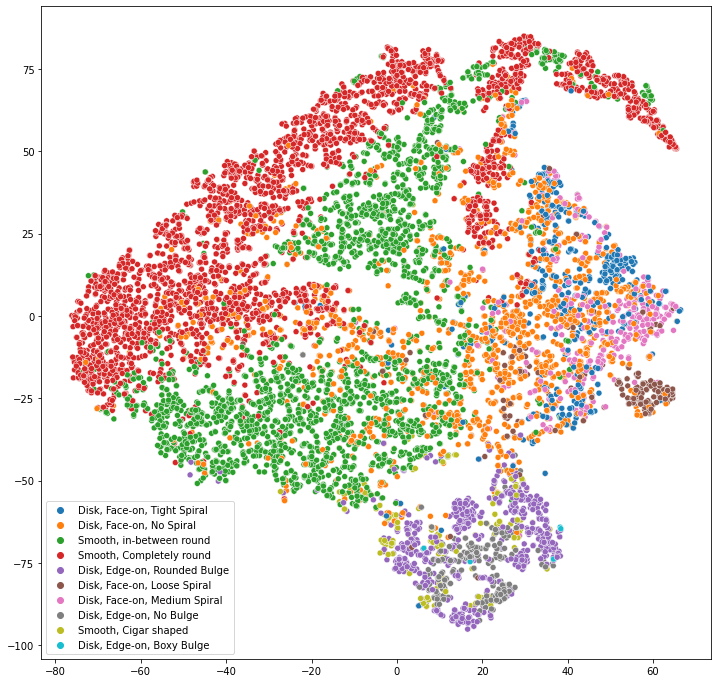

In [216]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30.0, n_jobs=4)
X = tsne.fit_transform(test_features)
fig = plt.figure(figsize=(12, 12))
sns.scatterplot(x=X[:,0], y=X[:, 1], hue=np.array([class_names[y] for y in y_test]))
plt.show()

This is more useful. This gives use an idea of the underlying topology of the data: which images are close to others? Are some classes mixed and difficult to separate?

For example, we can see that some classes are quite well delineated (e.g. smooth round galaxies) while the model seems to confuse a lot the various disk galaxies. More specifically, edge-on disk galaxies looks like they might be confused with smooth, cigar shaped galaxies. This is consistent with the confusion matrix and can help us "debug" the errors committed by the network.

As a faster and more scalable alternative to t-SNE, the more recent UMAP might be a good choice. Shapes differ but relative positions of classes should stay somewhat the same.

UMAP is available from its own Python package (`umap-learn`) but it uses the scikit-learn convention so you can just drop it in your code like any other `sklearn` estimator.

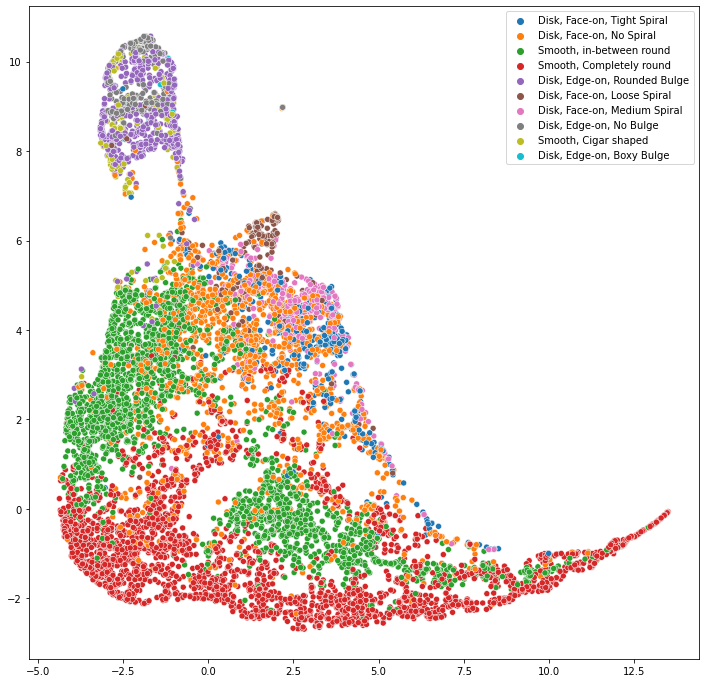

In [224]:
from umap import UMAP

um = UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X = um.fit_transform(test_features)
fig = plt.figure(figsize=(12, 12))
sns.scatterplot(x=X[:,0], y=X[:, 1], hue=np.array([class_names[y] for y in y_test]))#, palette=plt.cm.tab10)
plt.show()

## To go further

### Subclassing API

The `Sequential` API from PyTorch can also be used to define neural networks that are topologically simple. However, it is possible to have full control on the neural network architecture by using the subclassing API. In its core, this API consists in creating subclasses of the ``torch.nn.Module`` base class using Python.

Such a model must have at least two methods: `__init__()` (that creates the model) and `forward()` that performs the backward pass.

PyTorch uses automatic differentiation. This means that the gradients during the `backward()` are automatically computed, provided that you use `torch` operators! This makes it very easy to define custom networks and even custom layers.

See below for an example of how to define our Galaxy10 CNN using the subclassing API:

In [ ]:
import torch.nn.functional as F

class G10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G10CNN, self).__init__ # create the core of the module
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
        self.conv5 = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1)
        # Since Maxpooling has no parameters, we define it only once
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))
    
        
        # We can also combine modules
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                        nn.Flatten(),
                                        nn.Linear(256, num_classes))
    
    def forward(self, x):
        # This defines the forward pass
        # We apply all layers in succession but we create a more complex graph
        x = self.conv1(x)
        # We can apply ReLU as a function instead of defining a layer
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.conv3(x)
        x = F.relu(self.maxpool(x))
        x = self.conv4(x)
        x = F.relu(self.maxpool(x))
        x = self.conv5(x)
        # Final classification (Average Pooling + Flatten + linear classifier)
        x = self.classifier(x)
        return x

subclassed_cnn = G10CNN(num_classes=10)

### Build a pipeline

scikit-learn provides a nice tool for ML pipelines with multiple steps. Data processing in a sequence of several estimators (for example standardization + dimension reduction + clustering) can be error prone. For example, a very common error is to use standardization during training but not during inference. Another mistake consists in using test data to fit an estimator by mistake.

Wrapping all steps in one `Pipeline` makes the code simpler, easier to read and less error-prone. See the example below for a simple pipeline.

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2)), ('tree', DecisionTreeClassifier())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.828125

### On-the-shelf deep features

An interesting use of deep neural networks is feature extraction. Instead of designing expert features such as HOGs, you can use a pretrained deep neural network from the state-of-the-art, apply it on your data and use the activations from the last layer as a feature vector. This leverages the powerful pretrained model that has learnt on a very large dataset what images look like.

Of course, most pretrained models are trained for classification on everyday images for classes such as cats, dogs, phones and so on. But the convolutional filters these models have learnt are often very expressive and transfer to many domains!

It can be useful if you fall into one of the following usecases:
- if you don't have the computational power to train deep networks by yourself,
- you don't want to design a neural network and mess with optimization,
- you do not have a lot of data.

Let's see how one can use a pretrained model as a feature extractor. We will then use the usual SVM classification pipeline to train a galaxy classifier using deep features (but never needing to retrain the network ourself).

In [ ]:
import torch

from torch import nn

from tqdm import trange
from torchvision.models import densenet121

feature_net = nn.Sequential(*densenet121(pretrained=True).features[:-1])

features_train = extract_features(feature_net, images_train, transpose=False)

100%|██████████| 102/102 [00:53<00:00,  1.90it/s]


In [ ]:
features_train.shape

(13071, 1024)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(features_train)

#, 'kernel': ['linear', 'rbf'], 'gamma': ['auto', 'scale']
grid = {'C': [1e-2, 0.1, 1.0, 10, 100, 1000, 10000]}
model = GridSearchCV(LinearSVC(), grid, verbose=1, n_jobs=6)
model.fit(features_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:  7.6min finished


GridSearchCV(estimator=LinearSVC(), n_jobs=6,
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100, 1000, 10000]},
             verbose=1)

In [ ]:
features_test = extract_features(feature_net, images_test, transpose=False)

100%|██████████| 68/68 [00:34<00:00,  1.96it/s]


In [ ]:
svm.score(scaler.transform(features_test), y_test)

0.5906587101216433

In our case the off-the-shelf deep features do not perform very well, maybe because the semantic gap between ImageNet and Galaxy10 is too large.

### To go even further

This section mostly details some pointers and keywords to some interesting topics that have not been adressed in this tutorial.

#### Regression

Although this was not detailed in this tutorial, there are no limitations that prevent deep neural networks to be used for regression. Instead of having $k$ neurons (one for each class), the output layer can have as many neurons as target continuous variables to predict.

The loss function can be swapped to use for example the Mean Squared Error or any other measure of error that is differentiable (so that a gradient can be computed).

#### Unsupervised deep learning

Deep neural networks can work without supervision. This can be very useful to learn representations when the data is unlabeled, e.g. for image retrieval or clustering.

The seminal example of unsupervised neural networks is the [autoencoder](https://en.wikipedia.org/wiki/Autoencoder) where the model learns to compress the data and then reconstruct it to minimize the reconstruction error.

#### ML on time series/spectral data

Temporal or spectral data that can be represented as 1-D vectors can be processed similarly to tabular data. However, other specific models can be quite suited to this kind of homogeneous data:
- 1D convolutional neural networks for [time series](https://arxiv.org/pdf/1809.04356.pdf) or for [spectral data](https://www.mdpi.com/2220-9964/8/4/160/pdf),
- Recurrent neural networks, i.e. neural networks with temporal memory, especially useful for time series (see for example the [LSTM architecture](https://www.mitpressjournals.org/doi/full/10.1162/neco_a_01199) from [Hochreiter and Schmidhuber, 1997](https://www.mitpressjournals.org/doi/abs/10.1162/neco.1997.9.8.1735)).
- Dedicated toolboxes for time series such as [tslearn](https://tslearn.readthedocs.io/en/stable/) developed by Romain Tavenard.

#### Generative models and density estimation

Sometimes, just classification or regression is not enough. [Gaussian Mixture Models](https://scikit-learn.org/stable/modules/mixture.html) are a very useful tool to estimate the *probability density function* of your data. You can even sample new data from the PDF that you approximated.

Going one step further, the Generative Adversarial Networks use two neural networks in competition. The *Generator* tries to create new data that fool the *Discriminator* (or *Critic*), which tries to separate fake data from real data. See for example the original paper from [Goodfellow et al. 2015](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) for the idea.

## References

Readings to go deeper into the maze:

### Astrophysics and ML :

* AstroML: http://www.astroml.org/index.html
* AstroNN: https://astronn.readthedocs.io
* *Statistics, Data Mining, and Machine Learning in Astronomy*, 2013 (Ivezic, Conolly and VanderPlas)

### Deep Learning

* An overview of deep learning: *Deep Learning*, 2016 (Courville, Goodfellow and Bengio)
* To learn with code examples: *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, 2018 (Aurélien Géron)
* PyTorch documentation: https://pytorch.org/
* TensorFlow/Keras documentation: https://www.tensorflow.org/guide/keras?hl=fr

### Machine Learning

* If you like maths: *The Elements of Statistical Learning*, 2008 (Hastie, Tibshirani and Friedman)
* If you like Python: *Introduction to Machine Learning with Python*, 2016 (Andreas Müller and Sarah Guido)
* If you want to learn general data science: *Python Data Science Handbook*, 2016, (Jake VanderPlas)